<a href="https://colab.research.google.com/github/UNIST-LIM-Lab-course/gnn-assignment-xiyanafiguera/blob/main/gnn_node_classification_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN Node classification assignment

>
> The task objective is to classify seven types of nodes in the citation graph, which is the category of the paper:
>
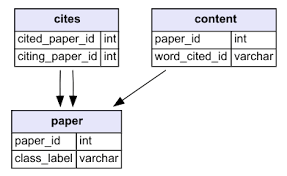
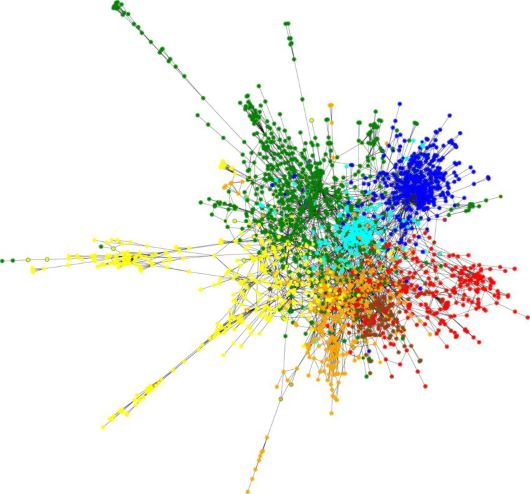
> Source: https://arxiv.org/abs/1611.08402.  
>
> We use a synthetic dataset, _CoraGraphDataset_ built in DGL. 

### Install DGL

In [1]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 281 kB 67.4 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


### Import modules

**Caution: Please do not import additional packages other than the ones below (this is for grading).**  
_* If you want to test or implement your own code that requires additional imports, please make a copy and work on the copy._

In [2]:
import dgl
from dgl.data import CoraGraphDataset
from dgl.dataloading import GraphDataLoader
import dgl.function as fn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import networkx as nx
import math

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


### Load dataset


In [3]:
transform = dgl.AddSelfLoop()  # by default, it will first remove self-loops to prevent duplication
dataset = CoraGraphDataset(transform=transform)

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [4]:
# Create dataset
dataset = CoraGraphDataset(transform=transform)
# only one graph exists with multiple nodes and edges
g = dataset[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
g = g.int().to(device)
features = g.ndata['feat']
labels = g.ndata['label']
masks = g.ndata['train_mask'], g.ndata['val_mask'], g.ndata['test_mask']
n_classes = dataset.num_classes
# normalization
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5).to(device)
norm[torch.isinf(norm)] = 0
g.ndata['norm'] = norm.unsqueeze(1)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


## **Instruction**

**1. Customize your GNN to classify the nodes in the graph. You may refer to literatures about GNN models, _i.e._, GIN, GAT, Graphormer, etc. Please do not re-use the code from the TA session.**  
**2. Customize your classifier model with your customized GNN. You may use addional modules, _i.e._, from Pytorch. Please do not use pre-defined modules from dgl library.**  
**3. Fill in the TODO part in the training code.**

* Checklists:  
a) Grading criteria: Points are given if all your code in this notebook is runnable and the final test accuracy is over 50%. Points are not given if the testing cell at the end of the notebook is modified or extra cells (including text) are added after the last cell.  
b) Testing your model with the testing cell is recommended.  
c) Please make sure that your code is properly committed to the github repository for grading.  

### 1. GNN Implementation: TODO

In [5]:
class CustomGNN(nn.Module):

    def __init__(self, in_feats, out_feats):
        '''
        ----------
        parameters
        ----------
        in_feats : int
            Input feature size; i.e, the number of dimensions of :math:`h_j^{(l)}`.
        out_feats : int
            Output feature size; i.e., the number of dimensions of :math:`h_i^{(l+1)}`.
        '''
        super(CustomGNN, self).__init__() 
        self._in_feats = in_feats
        self._out_feats = out_feats
        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.bias = nn.Parameter(torch.Tensor(out_feats))
        self.reset_parameters_xavier()

    def reset_parameters_xavier(self):
        nn.init.xavier_normal_(self.weight.data, gain=0.02) # Implement Xavier Uniform
        #nn.init.xavier_uniform_(self.weight.data) # Implement Xavier Uniform
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)
            
    def forward(self, graph, feat):
        '''
        ----------
        parameters
        ----------
        graph : DGLGraph
            The graph.
        feat : torch.Tensor or pair of torch.Tensor

        -------
        returns
        -------
        torch.Tensor
            The output feature
        '''
        with graph.local_scope():
            # TODO: Implement your GNN

            degree = graph.out_degrees().float()
            degree = degree.clamp(min=1)  
            
            norm = 1.0/degree             
            norm = norm.unsqueeze(-1)            

            aggr_fn = fn.copy_u('h', 'm')
            su_fn = fn.sum(msg='m', out='h')

            feat = feat * norm

            feature = torch.matmul(feat, self.weight)
            graph.srcdata['h'] = feature
            graph.update_all(aggr_fn, su_fn)
            out = graph.dstdata['h']                 

                   
            out += self.bias  

            return out


### 2. Custom Model Implementation: TODO

In [6]:
class CustomClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(CustomClassifier, self).__init__()
        self.conv1 = CustomGNN(in_dim, hidden_dim)
        self.conv2 = CustomGNN(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h):
        # TODO: Implement your classifier using the member modules in the class.  
        out = F.relu(self.conv1(g, h))
        out = F.relu(self.conv2(g, out))
        out = self.classify(out)

        return out

In [7]:
# Create model
model = CustomClassifier(features.shape[1], 64, dataset.num_classes).to(device)
# define train/val samples, loss function and optimizer
train_mask = masks[0]
val_mask = masks[1]
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### 3. Train your custom classifier: TODO

In [8]:
def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [9]:
loss = float('inf')
# training loop
# do not change the number of epochs, when submitting your final code
for epoch in range(100):
    model.train()
    acc = 0
    ##### TODO: #####
    # 1) get logits from the model
    # 2) calculate the loss using the loss function
    # 3) backpropagate the loss
    # 4) update the weights using the optimizer

    #################
    pred = model(g, features)
    loss = loss_function(pred, labels.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = evaluate(g, features, labels, val_mask, model)
    print("Epoch {:05d} | Loss {:.4f} | Accuracy {:.4f} "
            . format(epoch, loss.item(), acc))

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 00000 | Loss 1.9406 | Accuracy 0.1220 
Epoch 00001 | Loss 1.9311 | Accuracy 0.1400 
Epoch 00002 | Loss 1.9160 | Accuracy 0.3160 
Epoch 00003 | Loss 1.8939 | Accuracy 0.3160 
Epoch 00004 | Loss 1.8675 | Accuracy 0.3160 
Epoch 00005 | Loss 1.8447 | Accuracy 0.3160 
Epoch 00006 | Loss 1.8349 | Accuracy 0.3160 
Epoch 00007 | Loss 1.8299 | Accuracy 0.3160 
Epoch 00008 | Loss 1.8167 | Accuracy 0.3160 
Epoch 00009 | Loss 1.7975 | Accuracy 0.3160 
Epoch 00010 | Loss 1.7784 | Accuracy 0.3160 
Epoch 00011 | Loss 1.7605 | Accuracy 0.3160 
Epoch 00012 | Loss 1.7420 | Accuracy 0.3160 
Epoch 00013 | Loss 1.7237 | Accuracy 0.3160 
Epoch 00014 | Loss 1.7047 | Accuracy 0.3160 
Epoch 00015 | Loss 1.6803 | Accuracy 0.3160 
Epoch 00016 | Loss 1.6515 | Accuracy 0.3160 
Epoch 00017 | Loss 1.6236 | Accuracy 0.3160 
Epoch 00018 | Loss 1.6004 | Accuracy 0.3160 
Epoch 00019 | Loss 1.5783 | Accuracy 0.3160 
Epoch 00020 | Loss 1.5511 | Accuracy 0.3200 
Epoch 00021 | Loss 1.5217 | Accuracy 0.3300 
Epoch 0002

## Testing: DO NOT EDIT THE CELLS BELOW AND DO NOT ADD CELLS BELOW

In [10]:
# test the model
acc = evaluate(g, features, labels, masks[2], model)
print(acc)

0.946
